In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

from matplotlib import pyplot as plt

# Composition of *E. coli* biomass as a function of $\mu$

Bremer and Dennis EcoSal+ 2008 have a nice table of *E. coli* biomass composition as a function of growth rate that derives from Bipatnath, Dennis & Bremer 1998. This is preferable to the Taymaz-Nickerel reference in that all the data result from measurements and not inferences/assumptions. However they do not measure the lipid fraction of biomass. 

# Estimating the lipid fraction as a function of $\mu$
Harris & Theriot 2018 (Trends in Micro) propose a negative-slope linear relation between surface area to volume ratio (SA/V) and growth rate $\mu$. Their fit is $\frac{\text{SA}}{V} = –2.8\mu + 9.3$. 

To convert this into lipid fraction of total biomass ($F_l$), we need actualy measurements of lipid composition. The bionumbers book cites Neidhardt 1990, which gives 9.1% at a doubling time of 40 min ($\mu = 1.04$, see BNID 104954). A more recent work from Beck, Hunt & Carlson 2018 gives 6.7% in glucose minimal medium batch culture. There the growth rate is not documented. 

TODO: data on total lipid content somewhere?

In [2]:
# Load T-M data
bd_biomass_df = pd.read_excel('../data/BremerDennis_EcoSalPlus_2008.xlsx', index_col=0).T
bd_biomass_df.head()

parameter,protein_per_mass,RNA_per_mass,DNA_per_mass,cells_per_mass,protein_RNA_DNA_per_mass,protein_per_genome,RNA_per_genome,origins_per_genome,protein_per_origin,protein_per_cell,...,RNA_per_cell,RNA_ug_per_cell,DNA_per_cell,DNA_ug_per_cell,mass_per_cell,mass_ug_per_cell,protein_RNA_DNA_ug_per_cell,origins_per_cell,termini_per_cell,repl_forks_per_cell
symbol,PM,RM,GM,CM,PRDM,PG,RG,OG,PO,PC,...,RC,RC (μg),GC,GC (μg),MC,MC (μg),PRDC,OC,TC,FC
units,1e17 aa/OD460,1e16 nucl./OD460,1e8 genomes/OD460,1e8 cells/OD460,μg/OD460,1e8 aa residues,1e7 nucl. residues,no./genome equ.,1e8 aa residues,1e8 aa residues,...,1e7 nucl. residues,µg/1e9 cells,Genome equ./cell,µg/1e9 cells,OD460 units/1e9 cells,µg dry wt./1e9 cells,µg/1e9 cells,no./cell,no./cell,no./cell
u_0.6,5.8,3.3,12.0,7.7,128.0,4.8,2.8,1.3,3.9,7.6,...,4.3,23.0,1.6,7.6,1.3,226.0,167.0,2.0,1.2,1.5
u_1.0,5.5,3.8,9.1,4.6,124.0,6.0,4.1,1.4,4.4,11.9,...,8.1,44.0,2.0,9.5,2.2,374.0,267.0,2.7,1.4,2.7
u_1.5,5.1,4.4,7.8,3.1,119.0,6.6,5.6,1.7,4.4,16.4,...,14.0,76.0,2.5,12.0,3.2,555.0,383.0,3.8,1.5,4.4


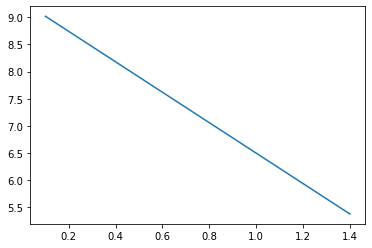

In [3]:
# SA/V as a function of growth rate from Harris & Theriot
# 
my_mus = np.arange(0.1, 1.5, 0.1)
SA_Vs_pred = -2.8*my_mus + 9.3

plt.plot(my_mus, SA_Vs_pred)
plt.show()


In [4]:
# grab only the rows corresponding to experiments
locs = [v for v in bd_biomass_df.index.values
        if v.startswith('u_')]
# calculate the mu values
mus = [float(v.strip('u_')) for v in locs]
sub_df = bd_biomass_df.loc[locs]

prot_ug = sub_df['protein_ug_per_cell']
RNA_ug = sub_df['RNA_ug_per_cell']
DNA_ug = sub_df['DNA_ug_per_cell']

prd_sum = sub_df['protein_RNA_DNA_ug_per_cell']
per_cell_mass = sub_df['mass_ug_per_cell']
residual_ug = per_cell_mass - prd_sum

print(prot_ug)
print(RNA_ug)
print(DNA_ug)
print(residual_ug)


# DNA and RNA are about 35% C by mass. Say +/- 3% 
prot_c_frac = 0.35

# Bulk protein is about 50% C by mass. Say +/- 3%
NA_c_frac = 0.5

# Sugars are ≈40% C, e.g. glucose and ribose. 
sugar_c_frac = 0.4 

# Lipids are about 75% C by mass, e.g. palmitate, oleate
lipid_c_frac = 0.75

nosc_ests = []
for _ in range(10000):
    # estimate the C mass for each component of known type
    prot_ug_c = prot_ug*np.random.normal(prot_c_frac, 0.03)
    RNA_ug_c = RNA_ug*np.random.normal(NA_c_frac, 0.03)
    DNA_ug_c = DNA_ug*np.random.normal(NA_c_frac, 0.03)
    
    # Based on http://book.bionumbers.org/what-is-the-macromolecular-composition-of-the-cell/
    # We will assume that the residual is lipids and sugars, each 40-60% of residual mass. 
    residual_sugar_frac = np.random.uniform(0.4, 0.6)
    residual_lipid_frac = 1 - residual_sugar_frac
    
    # Wider ranges on sugars and lipids because they could be a lot of different things.
    # e.g. sugars could be glycogen, peptidoglycans, LPS. Lipids could have many different
    # head groups, be sterols, etc. 
    sugar_c_f_sampled = np.random.normal(sugar_c_frac, 0.05)
    lipid_c_f_sampled = np.random.normal(lipid_c_frac, 0.05)
    
    sugars_ug_c = residual_ug*residual_sugar_frac*sugar_c_f_sampled
    lipids_ug_c = residual_ug*residual_lipid_frac*lipid_c_f_sampled
    
    # convert to umols carbon
    prot_umol_c = prot_ug_c/12.
    RNA_umol_c = RNA_ug_c/12.
    DNA_umol_c = DNA_ug_c/12.
    sugars_umol_c = sugars_ug_c/12.
    lipids_umol_c = lipids_ug_c/12.
    total_umol_c = prot_umol_c + RNA_umol_c + DNA_umol_c + sugars_umol_c + lipids_umol_c
    
    # convert to e- units with NOSC ranges
    # Coli coding sequences gives a range of -0.1 to -0.2 for protein roughly
    # This value depends on which proteins are expressed, so we don't have a strong prior.
    prot_umol_Ce = prot_umol_c*np.random.uniform(-0.2, -0.1)
    
    # NOSC for DNA at 50% GC content is +0.6 +/- a few percent (took 3%)
    # See Dick et al. Front. Micro 2019 for more on DNA and RNA NOSC.
    DNA_umol_Ce = DNA_umol_c*np.random.normal(0.6, 0.02)
    
    # NOSC for RNA at 50% GC content is +0.9 +/- a few percent (took 3%)
    # though ssRNA NOSC depends on all base abundances... 
    RNA_umol_Ce = RNA_umol_c*np.random.normal(0.9, 0.03)
    
    # Sugars have a NOSC around 0, sugar acids are more oxidized
    # sugar alcohols are more reduced. See LaRowe & Amend 2016, Table 1. 
    sugar_umol_Ce = sugars_umol_c*np.random.normal(0.0, 0.2)
    
    # Lipids have a NOSC ranging from -1.6 to -1.8. See LaRowe & Amend 2016, Table 1. 
    lipids_umol_Ce = lipids_umol_c*np.random.normal(-1.7, 0.2)
    
    # Total formal C-bound electrons
    total_umol_Ce = (
        prot_umol_Ce + DNA_umol_Ce + RNA_umol_Ce + 
        sugar_umol_Ce + lipids_umol_Ce)
    
    # Calculate and save NOSC = electrons/C
    nosc_ests.append(total_umol_Ce / total_umol_c)

nosc_est_df = pd.concat(nosc_ests, axis=1)


u_0.6    136.0
u_1.0    214.0
u_1.5    295.0
u_2.0    387.0
u_2.5    431.0
u_3.0    426.0
Name: protein_ug_per_cell, dtype: object
u_0.6     23.0
u_1.0     44.0
u_1.5     76.0
u_2.0    128.0
u_2.5    180.0
u_3.0    214.0
Name: RNA_ug_per_cell, dtype: object
u_0.6     7.6
u_1.0     9.5
u_1.5    12.0
u_2.0    14.7
u_2.5    17.2
u_3.0    19.4
Name: DNA_ug_per_cell, dtype: object
u_0.6     59.0
u_1.0    107.0
u_1.5    172.0
u_2.0    244.0
u_2.5    293.0
u_3.0    364.0
dtype: object


In [5]:
# convert to long form with mu in each row
nosc_est_long = nosc_est_df.melt(ignore_index=False)
nosc_est_long['mu'] = [float(v.strip('u_')) for v in nosc_est_long.index.values]
nosc_est_long.drop('variable', axis=1, inplace=True)
nosc_est_df

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
u_0.6,-0.41596,-0.259916,-0.353979,-0.263806,-0.289647,-0.26587,-0.310569,-0.206927,-0.34354,-0.312347,...,-0.21637,-0.261757,-0.268579,-0.26876,-0.366411,-0.377476,-0.465599,-0.302841,-0.304405,-0.407046
u_1.0,-0.438663,-0.268439,-0.370455,-0.274999,-0.30374,-0.276981,-0.320932,-0.212311,-0.364551,-0.3253,...,-0.22185,-0.269088,-0.279552,-0.278181,-0.384177,-0.398395,-0.491532,-0.314915,-0.317502,-0.426228
u_1.5,-0.45182,-0.26854,-0.377916,-0.277249,-0.307667,-0.278953,-0.321807,-0.208935,-0.376552,-0.329897,...,-0.217425,-0.265499,-0.28142,-0.278426,-0.392861,-0.407788,-0.507963,-0.316883,-0.322438,-0.435367
u_2.0,-0.426806,-0.24233,-0.353076,-0.252242,-0.277882,-0.249916,-0.289826,-0.179961,-0.355514,-0.305538,...,-0.186166,-0.230968,-0.252819,-0.251155,-0.367727,-0.377664,-0.483072,-0.287245,-0.297604,-0.407541
u_2.5,-0.394726,-0.210915,-0.322049,-0.221765,-0.241835,-0.215514,-0.252355,-0.146149,-0.327831,-0.275308,...,-0.149561,-0.190869,-0.218886,-0.218421,-0.336102,-0.340288,-0.45094,-0.251298,-0.267144,-0.372742
u_3.0,-0.429676,-0.225966,-0.347837,-0.239135,-0.264775,-0.235769,-0.273075,-0.157725,-0.357919,-0.296178,...,-0.159856,-0.204982,-0.238606,-0.234004,-0.363902,-0.371353,-0.491301,-0.270748,-0.289418,-0.402743


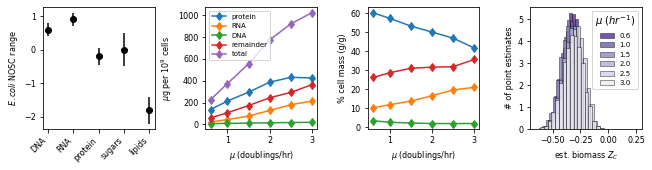

In [6]:
fig,axs = plt.subplots(ncols=4, figsize=(9,2.3))

# Rough NOSC plot of biomass components
plt.sca(axs[0])
labels = 'DNA,RNA,protein,sugars,lipids'.split(',')
xs = np.arange(len(labels))
ys = [0.6, 0.9, -0.2, 0, -1.8]
yerr = [0.2, 0.2, 0.25, 0.5, 0.4]
plt.errorbar(xs, ys, yerr=yerr, ls='', marker='o', c='k')

plt.xticks(xs, labels, rotation=45, ha='right', fontsize=8)
plt.xlabel('')
plt.ylabel('$E. coli$ NOSC range', fontsize=8)
plt.tick_params(axis='both', labelsize=8)

# Dependence of biomass content on growth rate in ug units
plt.sca(axs[1])
labels = 'protein,RNA,DNA'.split(',')
keys = ['{0}_ug_per_cell'.format(l) for l in labels]
locs = [v for v in bd_biomass_df.index.values
        if v.startswith('u_')]
mus = [float(v.strip('u_')) for v in locs]
sub_df = bd_biomass_df.loc[locs]

for l,k in zip(labels, keys):
    ys = sub_df[k]
    plt.plot(mus, ys, marker='d', label=l)

prd_sum = sub_df['protein_RNA_DNA_ug_per_cell']
per_cell_mass = sub_df['mass_ug_per_cell']
residual = per_cell_mass - prd_sum
plt.plot(mus, residual, marker='d', label='remainder')

plt.plot(mus, per_cell_mass, marker='d', label='total')

plt.xlabel('$\mu$ (doublings/hr)', fontsize=8)
plt.ylabel('$\mu$g per $10^9$ cells', fontsize=8)
plt.tick_params(axis='both', labelsize=8)
plt.legend(fontsize=7)

# Dependence of biomass composition (%) on growth rate
plt.sca(axs[2])
for l in labels:
    key = '{0}_ug_per_cell'.format(l)    
    ys = 100*sub_df[key] / sub_df['mass_ug_per_cell']
    plt.plot(mus, ys, marker='d', label=l)
    
resid_pct = 100*residual/per_cell_mass
plt.plot(mus, resid_pct, marker='d', label='remainder')

plt.xlabel('$\mu$ (doublings/hr)', fontsize=8)
plt.ylabel('% cell mass (g/g)', fontsize=8)
plt.tick_params(axis='both', labelsize=8)

plt.sca(axs[3])
pal = sns.color_palette('Purples')
for i, (rid, row) in enumerate(nosc_est_df.iterrows()):
    plt.hist(row.values, bins=20, edgecolor='k', lw=0.5, color=pal[-(i+1)], density=True, 
             label=mus[i], alpha=0.8)
plt.xlabel('est. biomass $Z_C$', fontsize=8)
plt.ylabel('# of point estimates', fontsize=8)
plt.tick_params(axis='both', labelsize=8)
plt.legend(fontsize=7, title='$\mu$ ($hr^{-1}$)')
plt.xlim(-0.7, 0.3)

plt.tight_layout(pad=0.5)
plt.savefig('../output/BremerDennis2008_EC_biomass_comp.png', facecolor='w', dpi=600)
plt.show()

<ErrorbarContainer object of 3 artists>

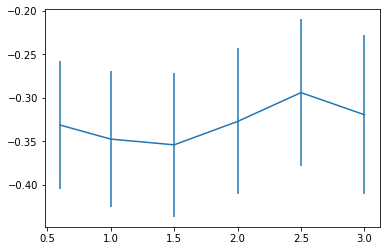

In [ ]:
mean_est = nosc_est_df.mean(axis=1)
std_est = nosc_est_df.std(axis=1)
plt.errorbar(mus, mean_est, yerr=std_est)

In [ ]:
mean

NameError: name 'mean' is not defined